# Metropolis Hastings
The Metropolis Hastings algorithm can be used to sample from a complex distriubtion, even when that distribution is unkown to the user. It's easy to find examples where the algorithm is used to sample from some know distribution, like the multivariate gaussian, but it can also be used to sample from the distribution over parameters of a model. In this example, we will use the MH algorithm to sample from the posterior distribution $P(\theta|data)$ where the data generating process is a mixture of two gaussian distributions. More formally:  

\begin{align*} 
p(z,x) & = p(z)p(x|z)\\
p(z) & \sim Mult(\pi_1, ..., pi_k)\\
p(x|z) &\sim N(\mu_k, \sigma_k)
\end{align*}

$z$ above represents the latent (unobserved) variable which is sampled from some multinomial distribution $p(z)$. This can be thought of as an indiator variable which selects some normal distribtuion to sample form. So for each sample generated, we select a distribution according to some probability, and then sample from that distribution. 

The algorithm works by producing a Markov Chain whose stationary distribution converges to a "target" distribution. This means that we will be simulating a Markov Chain where in the long run, the distribution of samples from the markov chain will look like samples from our target distribution. In this example our posterior distribution $p(\theta|data)$ is the distribution over the parameters that define our mixture model. The nice part about this method vs something like the EM algorithm, is that it provides full distributions over the parameters for better inference.


In [3]:
import numpy as np
from numpy.random import binomial, normal
import scipy.stats as st
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt

def data_gen(mu, sigmas, phi, n):
    """
    Generates samples from Mixture of 2 Gaussian Distributions
    """
    y = []
    for i in range(n):
        ind = binomial(1, phi, 1)
        if ind == 1:
            y.append(normal(mu[0], sigmas[0], 1))
        else:
            y.append(normal(mu[1], sigmas[1], 1))
    return np.array(y)

def mixture_log_lik(x, mu, sigma, phi):
    """
    Calculates Log Likelihood for Mixture of 2 Gaussians
    """
    lik = phi * norm.pdf(x, mu[0], sigma[0]) + (1-phi) * norm.pdf(x, mu[1], sigma[1])
    return np.log(lik).sum() 

def metropolis_hastings(p, data, iter=1000, burn_in=200):
    mu = [0., 1.] 
    sigmas = [1., 1.]
    phi = .5
    samples = np.zeros((iter, 5))

    for i in range(iter):
        # Update mu values
        mu1, mu2 = np.array(mu) + normal(0,.1,size=2)
        alpha = min(1, np.exp(p(data, [mu1, mu2], sigmas, phi) - p(data, mu, sigmas, phi)))
        if np.random.rand() < alpha:
            mu = [mu1, mu2]
        
        # Update Sigma values
        sigma1, sigma2 = np.array(sigmas) + normal(0,.1,size = 2)
        alpha = min(1, np.exp(p(data, mu, [sigma1, sigma2], phi) - p(data, mu, sigmas, phi)))
        if np.random.rand() < alpha:
            sigmas = [sigma1, sigma2]
        
        # Update Phi values
        phi_1 = phi + normal(0,.05,size = 1)
        alpha = min(1, np.exp(p(data, mu, sigmas, phi_1) - p(data, mu, sigmas, phi)))
        if np.random.rand() < alpha:
            phi = phi_1
        
        samples[i,0:2] = np.array(mu)
        samples[i,2:4] = np.array(sigmas)
        samples[i,4] = phi

    return samples[burn_in:]


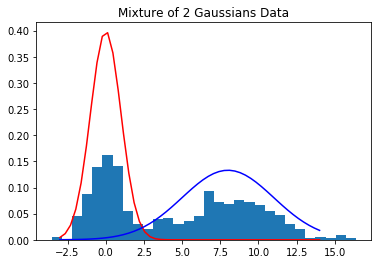

In [4]:
# Set Starting Parameters
mu = [0, 8]
sigmas = [1, 3]
phi = .4
n = 500
y = data_gen(mu=mu, sigmas=sigmas, phi=phi, n=n)
x = np.linspace(-3,14)

# Create Plot of Data 
plt.hist(y, 30, normed=True)
plt.plot(x, norm(mu[0], sigmas[0]).pdf(x), color="red")
plt.plot(x, norm(mu[1], sigmas[1]).pdf(x), color="blue")
plt.title("Mixture of 2 Gaussians Data")
plt.show()

## Estimating the Posterior
Point estimates of $\theta$ can be estimated by taking the mean of each Markov Chain. Note that the estimaated parameters closely align with our known parameters used to generate the data.

Phi: 0.42
mu1: -0.05
mu2: 7.96
sigma1: 1.03
sigma2: 3.05


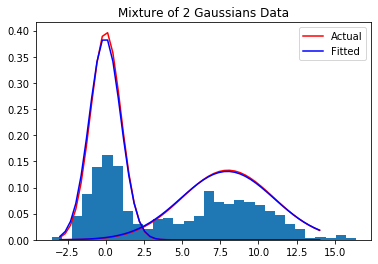

In [5]:
# Run the algorithm and extract the parameter values by taking means
trace = metropolis_hastings(mixture_log_lik, y, iter = 4000, burn_in=2000)
mu1 = np.round(np.mean(trace[:,0]),2)
mu2 = np.round(np.mean(trace[:,1]),2)
sigma1 = np.round(np.mean(trace[:,2]),2)
sigma2 = np.round(np.mean(trace[:,3]),2)
phi = np.round(np.mean(trace[:,4]),2)

print(f"Phi: {phi}\nmu1: {mu1}\nmu2: {mu2}\nsigma1: {sigma1}\nsigma2: {sigma2}")

# Plotting Fitted Params
plt.hist(y, 30, normed=True)
plt.plot(x, norm(mu[0], sigmas[0]).pdf(x), color="red", label="Actual")
plt.plot(x, norm(mu[1], sigmas[1]).pdf(x), color="red")
plt.plot(x, norm(mu1, sigma1).pdf(x), color="blue", label="Fitted")
plt.plot(x, norm(mu2, sigma2).pdf(x), color="blue")
plt.title("Mixture of 2 Gaussians Data")
plt.legend(loc="upper right")
plt.show()

# The Markov Chain and Full Posterior
As promised we can also view the Markov Chain to check for stationarity while also plotting each distribution over the parameter space.

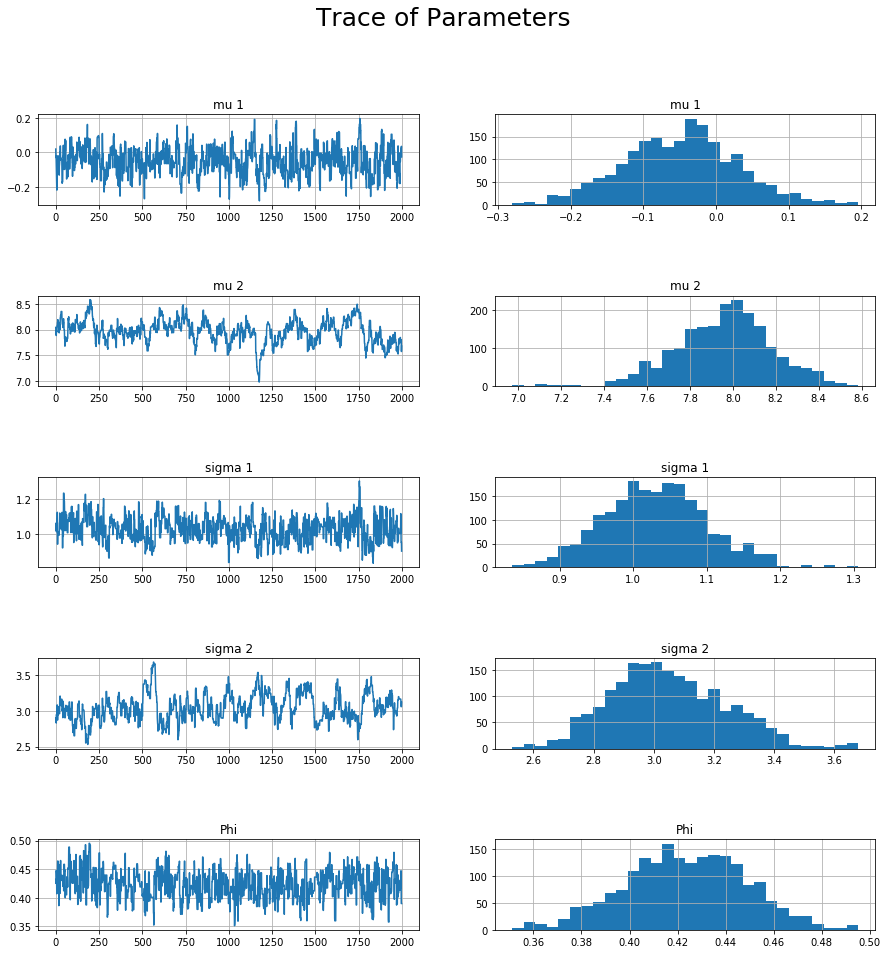

In [10]:
# Plotting Trace of Paameters Through the Markov Chain
fig, axs = plt.subplots(5,2)
x = range(trace.shape[0])
params = ["mu 1", "mu 2", "sigma 1", "sigma 2", "Phi"]
for i, v in enumerate(params):
    y = trace[:,i]
    axs[i,0].plot(x, y)
    axs[i,0].set_title(v)
    axs[i,1].hist(y, 30)
    axs[i,1].set_title(v)
    axs[i,0].grid()
    axs[i,1].grid()

fig.suptitle("Trace of Parameters", fontsize=25)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=1)
fig.show()